# Goal

Validation of fragment KDE estimation.

* Settings to test:
  * Trying differing bandwidths

# Setting variables

In [5]:
workDir = '/home/nick/notebook/SIPSim/dev/Ecoli/'
genomeDir = '/home/nick/notebook/SIPSim/dev/Ecoli/genomes/'

# Init

In [54]:
import glob
import nestly
from IPython.display import Image, display
import matplotlib.pyplot as plt

In [49]:
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

# Setting up nestly

In [88]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('bw', 
         ['scott',
          'silverman',
          1, 0.5, 0.1, 0.01, 0.001])

## set params
nest.add('np', [1], create_dir=False)

## input/output files
nest.add('fileName', ['ampFrags'], create_dir=False)
nest.add('genome_index', [os.path.join(genomeDir, 'genome_index.txt')], create_dir=False)
nest.add('genome_dir', [genomeDir], create_dir=False)
nest.add('primers', [os.path.join(workDir, '../', '515F-806R.fna')], create_dir=False)

# building directory tree
buildDir = os.path.join(workDir, 'frag_kde')
nest.build(buildDir)

In [89]:
bashFile = os.path.join(workDir, 'SIPSimRun.sh')

In [90]:
%%writefile $bashFile
#!/bin/bash

# simulating fragments
SIPSim fragments \
    {genome_index} \
    --fp {genome_dir} \
    --fr {primers} \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np {np} \
    2> {fileName}.log \
    > {fileName}.pkl
    
# converting to kde object
SIPSim fragment_kde \
    {fileName}.pkl \
    --bw {bw} \
    > {fileName}_kde.pkl    
    
# getting bandwidth (for checking on scott * silverman)    
SIPSim KDE_bandwidth {fileName}_kde.pkl > {fileName}_kde_bw.txt

Overwriting /home/nick/notebook/SIPSim/dev/Ecoli/SIPSimRun.sh


In [91]:
!chmod 775 $bashFile

In [92]:
!cd $workDir; \
    nestrun -j 10 --template-file $bashFile -d frag_kde

2015-07-12 19:09:55,090 * INFO * Template: ./SIPSimRun.sh
2015-07-12 19:09:55,092 * INFO * [79792] Started ./SIPSimRun.sh in frag_kde/0.5
2015-07-12 19:09:55,095 * INFO * [79793] Started ./SIPSimRun.sh in frag_kde/0.1
2015-07-12 19:09:55,098 * INFO * [79795] Started ./SIPSimRun.sh in frag_kde/0.01
2015-07-12 19:09:55,100 * INFO * [79797] Started ./SIPSimRun.sh in frag_kde/1
2015-07-12 19:09:55,101 * INFO * [79799] Started ./SIPSimRun.sh in frag_kde/scott
2015-07-12 19:09:55,103 * INFO * [79801] Started ./SIPSimRun.sh in frag_kde/0.001
2015-07-12 19:09:55,105 * INFO * [79803] Started ./SIPSimRun.sh in frag_kde/silverman
2015-07-12 19:09:59,098 * INFO * [79803] frag_kde/silverman Finished with 0
2015-07-12 19:09:59,107 * INFO * [79793] frag_kde/0.1 Finished with 0
2015-07-12 19:09:59,110 * INFO * [79795] frag_kde/0.01 Finished with 0
2015-07-12 19:09:59,116 * INFO * [79799] frag_kde/scott Finished with 0
2015-07-12 19:09:59,121 * INFO * [79792] frag_kde/0.5 Finished with 0
2015-07-12 19:

# Plotting

In [93]:
!cd $workDir; \
    find . -name "*_kde.pkl" | \
    perl -pe 's/\.pkl//' | \
    xargs -I % -P 5 SIPSim KDE_plot %.pkl -o %.png

Processing KDE for taxon: "Ecoli_O157H7"
Processing KDE for taxon: "Ecoli_O157H7"
Processing KDE for taxon: "Ecoli_O157H7"
Processing KDE for taxon: "Ecoli_O157H7"
Processing KDE for taxon: "Ecoli_O157H7"
File written: "./frag_kde/0.01/ampFrags_kde.png"
File written: "./frag_kde/scott/ampFrags_kde.png"
File written: "./frag_kde/0.5/ampFrags_kde.png"
File written: "./frag_kde/1/ampFrags_kde.png"
Processing KDE for taxon: "Ecoli_O157H7"
File written: "./frag_kde/0.1/ampFrags_kde.png"
Processing KDE for taxon: "Ecoli_O157H7"
File written: "./frag_kde/0.001/ampFrags_kde.png"
File written: "./frag_kde/silverman/ampFrags_kde.png"


/home/nick/notebook/SIPSim/dev/Ecoli/frag_kde/0.001/ampFrags_kde.png
Ecoli_O157H7	0.001


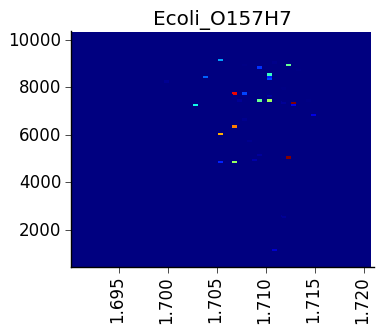

/home/nick/notebook/SIPSim/dev/Ecoli/frag_kde/0.01/ampFrags_kde.png
Ecoli_O157H7	0.01


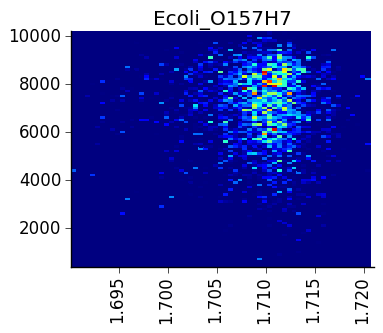

/home/nick/notebook/SIPSim/dev/Ecoli/frag_kde/0.1/ampFrags_kde.png
Ecoli_O157H7	0.1


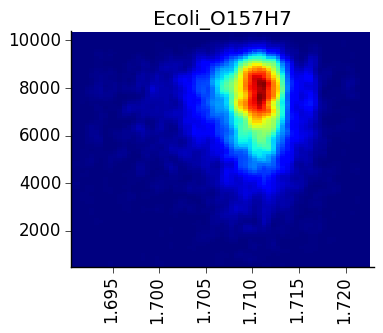

/home/nick/notebook/SIPSim/dev/Ecoli/frag_kde/0.5/ampFrags_kde.png
Ecoli_O157H7	0.5


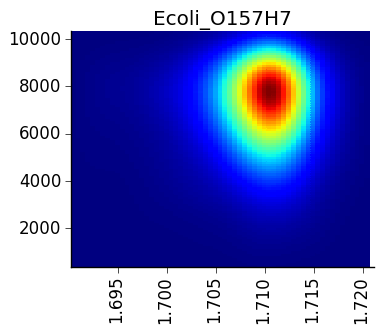

/home/nick/notebook/SIPSim/dev/Ecoli/frag_kde/1/ampFrags_kde.png
Ecoli_O157H7	1.0


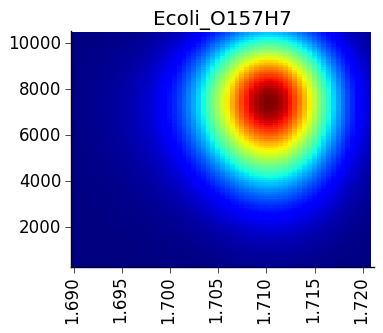

/home/nick/notebook/SIPSim/dev/Ecoli/frag_kde/scott/ampFrags_kde.png
Ecoli_O157H7	0.215443469003


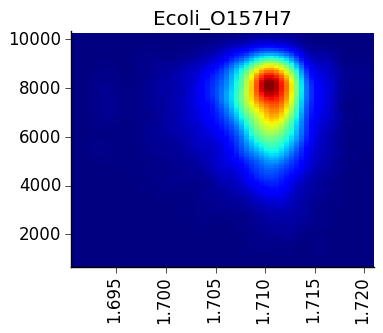

/home/nick/notebook/SIPSim/dev/Ecoli/frag_kde/silverman/ampFrags_kde.png
Ecoli_O157H7	0.215443469003


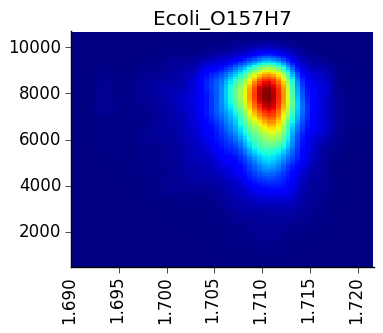

In [94]:
tmpDir = os.path.join(workDir, 'frag_kde')
pngs = glob.glob(os.path.join(tmpDir, '*/*_kde.png'))
bw = glob.glob(os.path.join(tmpDir, '*/*_kde_bw.txt'))

for x,y in zip(sorted(pngs), sorted(bw)):
    print x 
    !cat $y
    img = Image(x)
    display(img)